# Logistic Regression Notebook - Celestial Object Classification

# Introduction

###### The Problem

The University of Washington (“The Client”) has come to us to assist in classifying celestial objects observed by the their newly upcoming sky-survey.
The University of Washington has hand-classified celestial objects in the past, however, with the new volume of observations coming in with their new survey they would like to automate the classification process.
The University of Washington’s top priority for classification is overall accuracy.


###### The Metric

Accuracy is the metric of choice for this predictive model. The overall accuracy of the sky-survey is the most important aspect of this predictive model; The difference between false negatives and false positives is unimportant in the context of a large sky survey for astronomy

## Initial Data Exploration

In [1]:
#Importing EDA Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Importing the Star Classification Dataset

In [2]:
Stars = pd.read_csv("data/star_classification.csv")

###### Investigating Numeric Columns

In [3]:
Stars.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


###### Investigating Column Datatypes

In [4]:
Stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

###### All columns are numeric columns and are reflective of a spectroscoping observation

###### All columns are numeric except for target "class" variable

###### Ensuring Dataset is complete with no nulls

In [5]:
#Checking for Null's 
Stars.isnull().any()

obj_ID         False
alpha          False
delta          False
u              False
g              False
r              False
i              False
z              False
run_ID         False
rerun_ID       False
cam_col        False
field_ID       False
spec_obj_ID    False
class          False
redshift       False
plate          False
MJD            False
fiber_ID       False
dtype: bool

### Exploratory Data Analysis

###### Investigating the Distribution of Celestial Object Observations

<AxesSubplot:xlabel='class', ylabel='Count'>

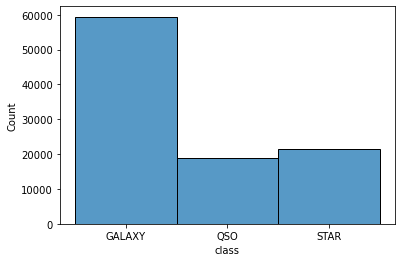

In [6]:
#plotting histogram of class occurance
sns.histplot(data = Stars, x="class", palette = "pastel") 

In [7]:
#ratio of class occurance
Stars["class"].value_counts(normalize = True)

GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: class, dtype: float64

###### Galaxies are the most common observation in the survey sample, representing roughly 60% of observations. Dataset is reasonably balanced

###### Importing Relevent ML Modules

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix

###### Investigating Correlations to Investigate Possible Collinearity

In [9]:
corr_matrix = Stars.corr()

In [10]:
corr_matrix

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013735,-0.301237,0.015310,0.015710,0.153891,0.147670,0.013811,1.000000,NaN,-0.046997,0.031498,0.239461,0.065400,0.239460,0.262687,0.067178
alpha,-0.013735,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,-0.013737,NaN,0.019582,-0.165577,-0.002553,0.001667,-0.002554,0.019943,0.030464
delta,-0.301237,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,-0.301238,NaN,0.032565,-0.173416,0.112329,0.031638,0.112329,0.107333,0.028250
u,0.015310,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.015309,NaN,0.003548,-0.008374,0.029997,0.014309,0.029997,0.031997,0.016305
g,0.015710,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.015710,NaN,0.003508,-0.008852,0.039443,0.022954,0.039443,0.040274,0.017470
r,0.153891,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.153889,NaN,0.008480,-0.026423,0.655245,0.433241,0.655243,0.671180,0.223106
i,0.147670,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.147668,NaN,0.007615,-0.026679,0.661641,0.492383,0.661640,0.672523,0.214787
z,0.013811,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.013811,NaN,0.003365,-0.008903,0.037813,0.030380,0.037813,0.037469,0.014668
run_ID,1.000000,-0.013737,-0.301238,0.015309,0.015710,0.153889,0.147668,0.013811,1.000000,NaN,-0.047098,0.031498,0.239460,0.065400,0.239459,0.262687,0.067165
rerun_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

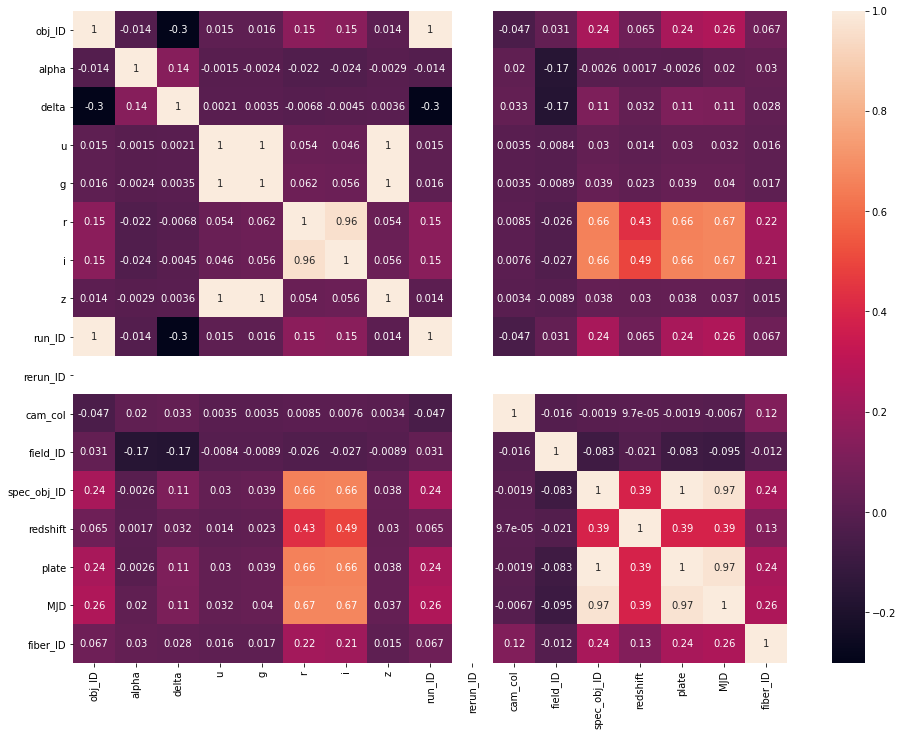

In [11]:
fig, ax = plt.subplots(figsize = (16, 12))
sns.heatmap(corr_matrix, annot=True)

###### Z, U, AND G are highly collinear; R and I are highly collinear

In [12]:
corr_matrix

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013735,-0.301237,0.015310,0.015710,0.153891,0.147670,0.013811,1.000000,NaN,-0.046997,0.031498,0.239461,0.065400,0.239460,0.262687,0.067178
alpha,-0.013735,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,-0.013737,NaN,0.019582,-0.165577,-0.002553,0.001667,-0.002554,0.019943,0.030464
delta,-0.301237,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,-0.301238,NaN,0.032565,-0.173416,0.112329,0.031638,0.112329,0.107333,0.028250
u,0.015310,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.015309,NaN,0.003548,-0.008374,0.029997,0.014309,0.029997,0.031997,0.016305
g,0.015710,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.015710,NaN,0.003508,-0.008852,0.039443,0.022954,0.039443,0.040274,0.017470
r,0.153891,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.153889,NaN,0.008480,-0.026423,0.655245,0.433241,0.655243,0.671180,0.223106
i,0.147670,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.147668,NaN,0.007615,-0.026679,0.661641,0.492383,0.661640,0.672523,0.214787
z,0.013811,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.013811,NaN,0.003365,-0.008903,0.037813,0.030380,0.037813,0.037469,0.014668
run_ID,1.000000,-0.013737,-0.301238,0.015309,0.015710,0.153889,0.147668,0.013811,1.000000,NaN,-0.047098,0.031498,0.239460,0.065400,0.239459,0.262687,0.067165
rerun_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Removing Collinear Features; Dropping Z, U and I

In [13]:
Feature_Vars = ["alpha","delta","r","g","redshift","class"]

In [14]:
variables = ["alpha","delta","r","g","redshift"]

In [15]:
Stars_Feature_Vars = Stars[Feature_Vars]

In [17]:
corr_matrix_2 = Stars_Feature_Vars.corr()

<AxesSubplot:>

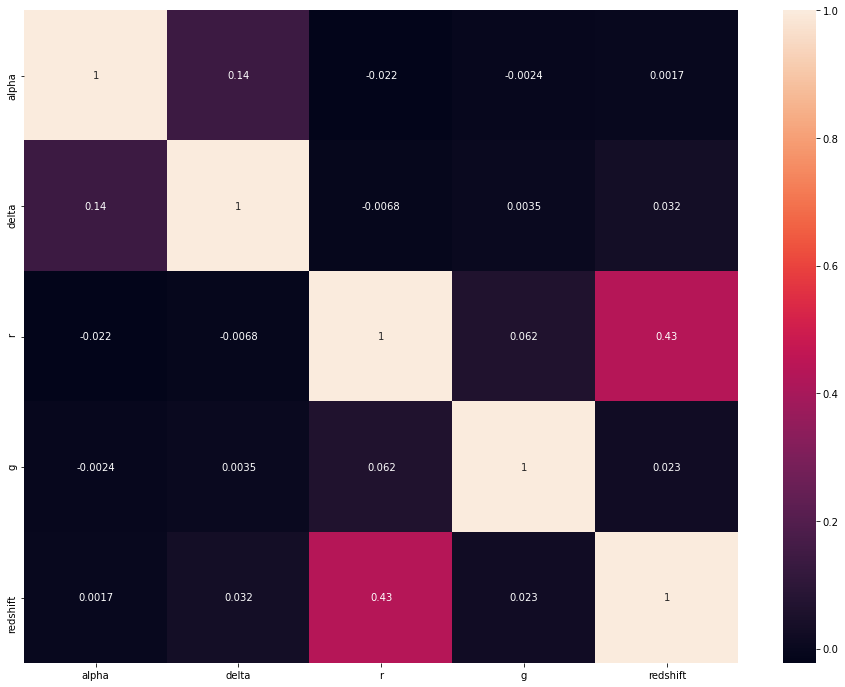

In [19]:
fig, ax = plt.subplots(figsize = (16, 12))
sns.heatmap(corr_matrix_2, annot=True)

In [20]:
Stars_Feature_Vars_Sample = Stars_Feature_Vars.sample(frac = 0.05)

In [21]:
variables

['alpha', 'delta', 'r', 'g', 'redshift']

###### Initializing Pairplot with 5% Sample of Overall Dataset

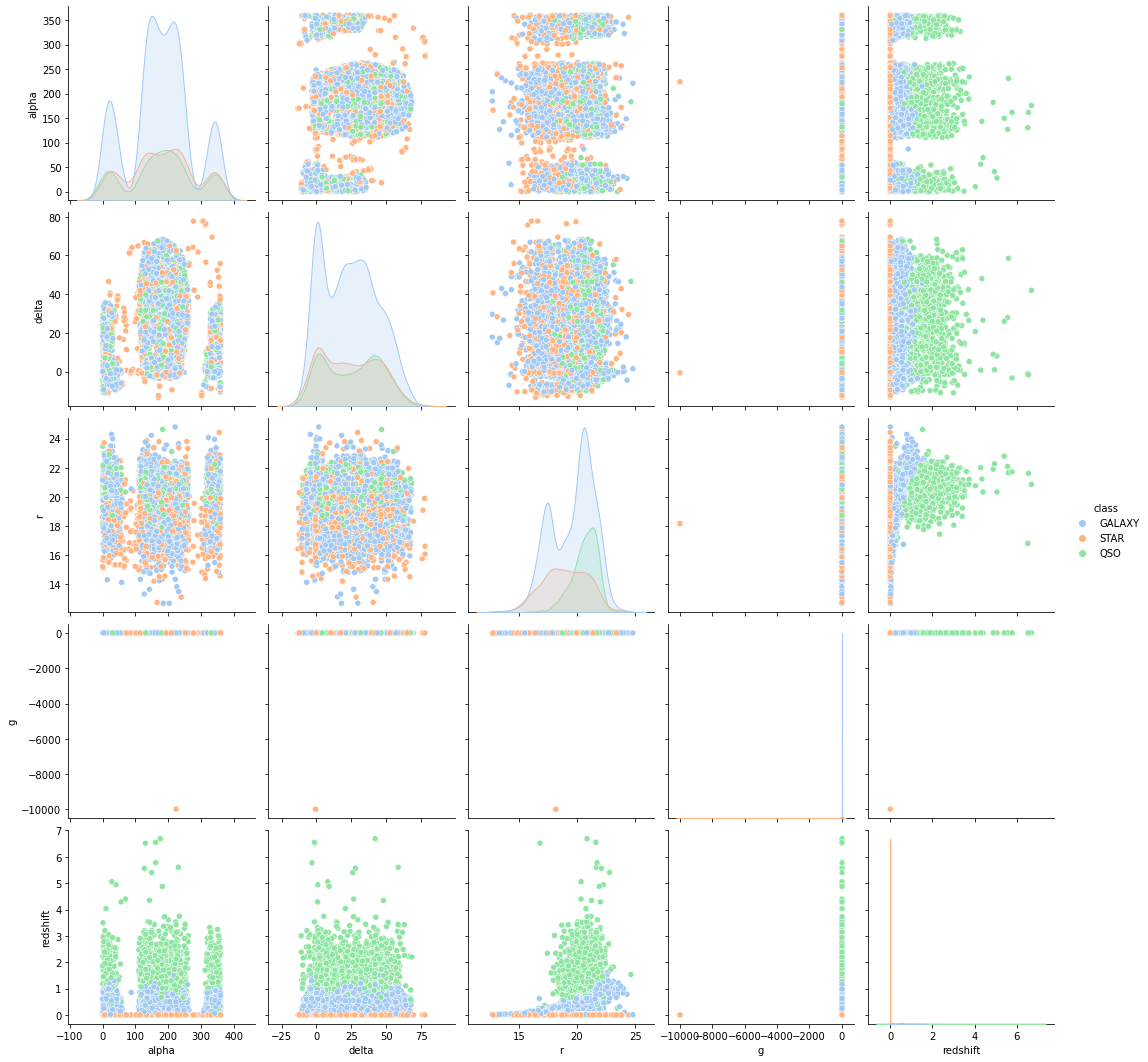

In [22]:
sns.pairplot(Stars_Feature_Vars_Sample, hue='class', diag_kind='kde', palette='pastel', height = 3)


###### Most Differentiated Category by Far is Redshift

## Preprocessing Data

###### Encoding Labels to Numeric Values for Logistic Regression Model

In [23]:
Label_Encoder = LabelEncoder()
Labels = ["GALAXY", "STAR", "QSO"]

In [24]:
Stars["Class"] = Label_Encoder.fit_transform(Stars["class"])

In [25]:
Stars["Class"].value_counts(normalize = True)

0    0.59445
2    0.21594
1    0.18961
Name: Class, dtype: float64

###### Selecting Target and Independent Variables

In [26]:
X = Stars[['alpha', 'delta', 'r', 'g', 'redshift']]
y = Stars["Class"]


###### Splitting Train and Test Data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

###### Scaling the X_Train and X_test

In [28]:
StandardScaler = StandardScaler()

In [29]:
x_train_scaled = StandardScaler.fit_transform(x_train)

In [30]:
x_test_scaled = StandardScaler.transform(x_test)

###### Intializing the Baseline Logistic Regression Model

In [31]:
logreg_baseline = LogisticRegression(max_iter=1000)

In [32]:
logreg_baseline.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000)

###### Evaluating Model Accuracy on Training Set

In [33]:
y_train_pred=logreg_baseline.predict(x_train_scaled)

In [34]:
train_accuracy = accuracy_score(y_train, y_train_pred)

In [35]:
train_accuracy

0.95015

###### Intializing Confusion Matrix to Evaluate Model Performance on Training Set

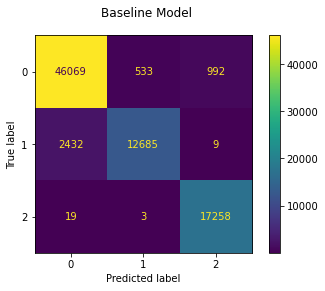

In [36]:
fig, ax = plt.subplots()

fig.suptitle("Baseline Model")

plot_confusion_matrix(logreg_baseline, x_train_scaled, y_train, ax=ax)

###### Cross Validation -  Baseline Model

In [37]:
cv_results = cross_validate(estimator = logreg_baseline,
                            X = x_train_scaled,
                            y = y_train,
                            cv = 5,
                            return_train_score =True)




In [38]:
cv_results

{'fit_time': array([0.91869497, 0.72601056, 0.80201674, 0.72407842, 1.11248207]),
 'score_time': array([0.00105667, 0.00099921, 0.00200844, 0.00195742, 0.0010004 ]),
 'test_score': array([0.9515625, 0.9483125, 0.950125 , 0.94775  , 0.949875 ]),
 'train_score': array([0.95125   , 0.94940625, 0.94914062, 0.94973438, 0.9491875 ])}

In [39]:
cv_results["test_score"]

array([0.9515625, 0.9483125, 0.950125 , 0.94775  , 0.949875 ])

###### Saving Baseline Model for Comparison

In [40]:
models = {}
models["baseline_model"] = {"model" : logreg_baseline, "cv":cv_results}

## Manual Hyperparameter Tuning

### Tuning for Regularization

In [41]:
c_values = [.001, .01, 1, 10, 100, 1000, 10000]

In [42]:
for c in (c_values):
    new_model = LogisticRegression(C=c, max_iter = 1000)
    cv_results = cross_validate(estimator = new_model,
                            X = x_train_scaled,
                            y = y_train,
                            cv = 5,
                            return_train_score =True,
                            n_jobs = 20)
    models[c] = cv_results
    


In [43]:
models

{'baseline_model': {'model': LogisticRegression(max_iter=1000),
  'cv': {'fit_time': array([0.91869497, 0.72601056, 0.80201674, 0.72407842, 1.11248207]),
   'score_time': array([0.00105667, 0.00099921, 0.00200844, 0.00195742, 0.0010004 ]),
   'test_score': array([0.9515625, 0.9483125, 0.950125 , 0.94775  , 0.949875 ]),
   'train_score': array([0.95125   , 0.94940625, 0.94914062, 0.94973438, 0.9491875 ])}},
 0.001: {'fit_time': array([0.31300545, 0.30899858, 0.30500293, 0.3130219 , 0.29800248]),
  'score_time': array([0.00100064, 0.00100136, 0.00099635, 0.00100255, 0.0010004 ]),
  'test_score': array([0.815625 , 0.815125 , 0.8178125, 0.814125 , 0.8171875]),
  'train_score': array([0.81717187, 0.8158125 , 0.81607812, 0.81584375, 0.81528125])},
 0.01: {'fit_time': array([0.41099811, 0.48297739, 0.59111452, 0.46799827, 0.44100094]),
  'score_time': array([0.00100398, 0.0010016 , 0.00088286, 0.00200129, 0.00099802]),
  'test_score': array([0.922875 , 0.9196875, 0.9210625, 0.9206875, 0.92231

###### It's clear that weaker regularization (Higher C-Values) yields better results on test and train cross-validation results

###### Finding the optimal C-Value for the best accuracy result

In [44]:

cv_scores = {}
for model in models:
    model_data = models[model]
    if 'test_score' in model_data:
        mean_train_score = model_data['train_score'].mean()
        cv_scores[F"{model} train score"] = mean_train_score
        mean_test_score = model_data['test_score'].mean()
        cv_scores[F"{model} test score"] = mean_test_score
print(cv_scores)


{'0.001 train score': 0.8160375, '0.001 test score': 0.8159750000000001, '0.01 train score': 0.92125, '0.01 test score': 0.9213250000000001, '1 train score': 0.94974375, '1 test score': 0.9495250000000001, '10 train score': 0.9557249999999999, '10 test score': 0.9558625, '100 train score': 0.9584781250000001, '100 test score': 0.9585374999999999, '1000 train score': 0.9592906250000001, '1000 test score': 0.9592875, '10000 train score': 0.9595906249999999, '10000 test score': 0.9594250000000001}


###### Test scores seem to plateau at 100 so we will use C=100 as our regularization hyperparameter

### Tuning Solvers

In [45]:
Solvers = ["lbfgs", "liblinear", "newton-cg", "sag", "saga" ]

In [46]:
for solver in Solvers:
    new_model = LogisticRegression(C=100, max_iter = 10000, solver = solver)
    cv_results = cross_validate(estimator = new_model,
                            X = x_train_scaled,
                            y = y_train,
                            cv = 5,
                            return_train_score =True,
                            n_jobs = 20)
    models[solver] = cv_results


In [47]:
models

{'baseline_model': {'model': LogisticRegression(max_iter=1000),
  'cv': {'fit_time': array([0.91869497, 0.72601056, 0.80201674, 0.72407842, 1.11248207]),
   'score_time': array([0.00105667, 0.00099921, 0.00200844, 0.00195742, 0.0010004 ]),
   'test_score': array([0.9515625, 0.9483125, 0.950125 , 0.94775  , 0.949875 ]),
   'train_score': array([0.95125   , 0.94940625, 0.94914062, 0.94973438, 0.9491875 ])}},
 0.001: {'fit_time': array([0.31300545, 0.30899858, 0.30500293, 0.3130219 , 0.29800248]),
  'score_time': array([0.00100064, 0.00100136, 0.00099635, 0.00100255, 0.0010004 ]),
  'test_score': array([0.815625 , 0.815125 , 0.8178125, 0.814125 , 0.8171875]),
  'train_score': array([0.81717187, 0.8158125 , 0.81607812, 0.81584375, 0.81528125])},
 0.01: {'fit_time': array([0.41099811, 0.48297739, 0.59111452, 0.46799827, 0.44100094]),
  'score_time': array([0.00100398, 0.0010016 , 0.00088286, 0.00200129, 0.00099802]),
  'test_score': array([0.922875 , 0.9196875, 0.9210625, 0.9206875, 0.92231

In [48]:
solver_scores = {}
for model in models:
    model_data = models[model]
    if 'test_score' in model_data:
        solver_train_score = model_data['train_score'].mean()
        solver_scores[F"{model} train score"] = solver_train_score
        solver_test_score = model_data['test_score'].mean()
        solver_scores[F"{model} test score"] = solver_test_score
print(solver_scores)


{'0.001 train score': 0.8160375, '0.001 test score': 0.8159750000000001, '0.01 train score': 0.92125, '0.01 test score': 0.9213250000000001, '1 train score': 0.94974375, '1 test score': 0.9495250000000001, '10 train score': 0.9557249999999999, '10 test score': 0.9558625, '100 train score': 0.9584781250000001, '100 test score': 0.9585374999999999, '1000 train score': 0.9592906250000001, '1000 test score': 0.9592875, '10000 train score': 0.9595906249999999, '10000 test score': 0.9594250000000001, 'lbfgs train score': 0.9584781250000001, 'lbfgs test score': 0.9585374999999999, 'liblinear train score': 0.9540468750000001, 'liblinear test score': 0.953975, 'newton-cg train score': 0.95848125, 'newton-cg test score': 0.9585374999999999, 'sag train score': 0.9485250000000001, 'sag test score': 0.9484124999999999, 'saga train score': 0.947196875, 'saga test score': 0.947125}


###### The Newton-Cg or LBFGS solver seems to be optimal for this problem; LBFGS may be computantianally more effecient as seen in the fit time array on cross validation

## Validating Final Model

In [49]:
logreg_final = LogisticRegression(max_iter=10000, solver = "newton-cg", C=100)


In [50]:
logreg_final.fit(x_train_scaled, y_train)

LogisticRegression(C=100, max_iter=10000, solver='newton-cg')

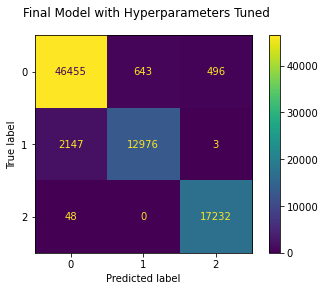

In [51]:
fig, ax = plt.subplots()

fig.suptitle("Final Model with Hyperparameters Tuned")

plot_confusion_matrix(logreg_final, x_train_scaled, y_train, ax=ax)

In [52]:
logreg_final.score(x_train_scaled, y_train)

0.9582875

In [60]:
y_pred_final_train = logreg_final.predict(x_train_scaled)

In [61]:
final_model_accuracy_train = accuracy_score(y_train, y_pred_final_train)

In [62]:
final_model_accuracy_train

0.9582875

### Comparing Final Model with Baseline Model on Test Data

###### Evaluating Accuracy of Baseline and Final Models

In [53]:
y_pred_final = logreg_final.predict(x_test_scaled)

In [54]:
final_model_accuracy = accuracy_score(y_test, y_pred_final)

In [55]:
y_pred_baseline = logreg_baseline.predict(x_test_scaled)

In [56]:
baseline_model_accuracy = accuracy_score(y_test, y_pred_baseline)

In [57]:
print(F"Final Model Accuracy: {final_model_accuracy*100}%")
print(F"Baseline Model Accuracy: {baseline_model_accuracy*100}%")

Final Model Accuracy: 95.665%
Baseline Model Accuracy: 94.91000000000001%


###### Evaluating Model Performance of Baseline and Final Models with Confusion Matrices

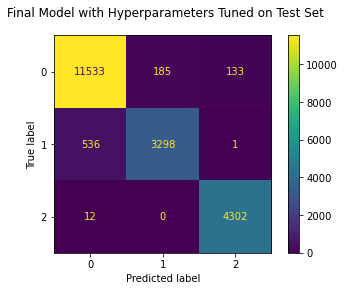

In [58]:
fig, ax = plt.subplots()

fig.suptitle("Final Model with Hyperparameters Tuned on Test Set")

plot_confusion_matrix(logreg_final, x_test_scaled, y_test, ax=ax)

###### Recommendations

###### Obviously the biggest challenge comes with distinguishing Galaxies (0) and Quasars (1). Given this additional features such as luminosity of radio spectra should be included to increase accuracy in distinguishing these two classes